# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
import visualize

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [4]:
# print model summary
keras_model = model.keras_model
print(keras_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_image (InputLayer)         (None, 1024, 1024, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 1030, 1030, 3) 0           input_image[0][0]                
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 512, 512, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNorm)             (None, 512, 512, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

In [165]:
from PIL import Image
from PIL import ExifTags
def PIL2array(img):
    if hasattr(img._getexif(), 'items'):
        exif = {
        ExifTags.TAGS[k]: v
        for k, v in img._getexif().items()
        if k in ExifTags.TAGS
        }
        orientation = 'Orientation'
        if hasattr(exif, orientation):
            if   exif[orientation] == 3 : 
                img=img.rotate(180, expand=True)
            elif exif[orientation] == 6 : 
                img=img.rotate(270, expand=True)
            elif exif[orientation] == 8 : 
                img=img.rotate(90, expand=True)
    return np.array(img.getdata(), np.uint8).reshape(img.size[1], img.size[0], 3)

def array2PIL(arr, size):
    mode = 'RGBA'
    arr = arr.reshape(arr.shape[0]*arr.shape[1], arr.shape[2])
    if len(arr[0]) == 3:
        arr = np.c_[arr, 255*np.ones((len(arr),1), np.uint8)]
    return Image.frombuffer(mode, size, arr.tostring(), 'raw', mode, 0, 1)

In [46]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = Image.open('/Users/louis/Desktop/crnn_test.JPG')
image_data = PIL2array(image)
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
# Run detection
results = model.detect([image_data], verbose=1)



Processing 1 images
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000
image_metas              shape: (1, 89)               min:    0.00000  max: 4032.00000


In [155]:
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib.patches import Polygon
def draw_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    figsize: (optional) the size of the image.
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        #檢查info size是不是一樣
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    if not ax:
        fig, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors
    colors = visualize.random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)

        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        masked_image = visualize.apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = visualize.find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    canvas = FigureCanvas(fig)
    canvas.draw()
    resultImage = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
    return resultImage
#     resultImage.show()
#     plt.show()

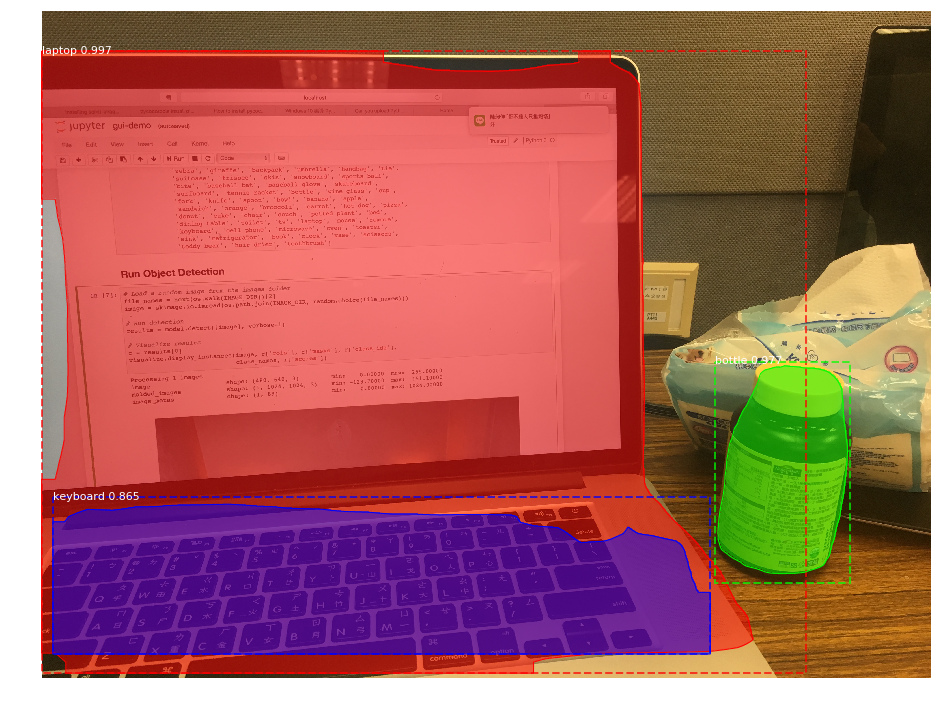

In [156]:
# Visualize results
r = results[0]
# print(r['rois'])
# print(r['masks'].shape)
# print(r['class_ids'])
# image_data = visualize.draw_box(image_data, r['rois'][0], [200, 100, 100])
# finalImage = array2PIL(image_data, image.size)
# finalImage.show()
finalImage = draw_instances(image_data, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
finalImage.show()
# def display_instances(image, boxes, masks, class_ids, class_names,
#                       scores=None, title="",
#                       figsize=(16, 16), ax=None):
# visualize.display_instances(image_data)

# GUI Console

A quick intro to using the pre-trained model to detect and segment objects.

Processing 1 images
image                    shape: (350, 500, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Processing 1 images
image                    shape: (1025, 1500, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1500.00000


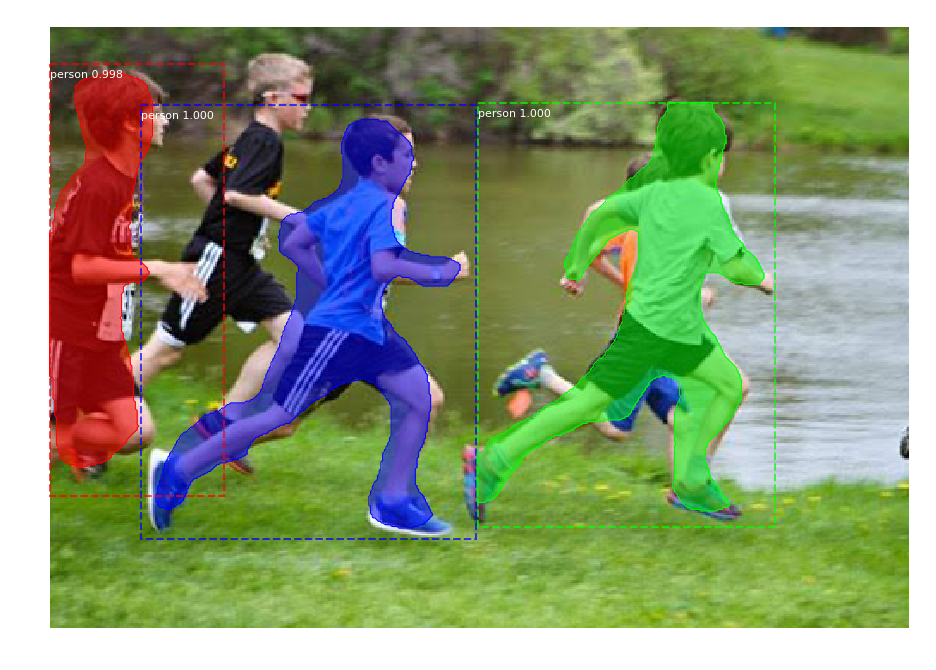

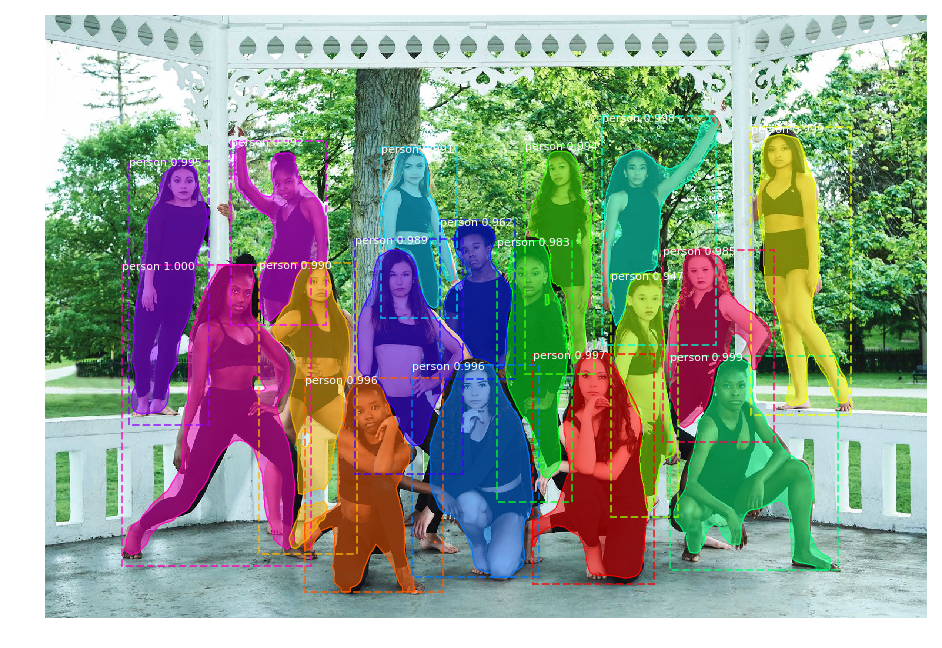

In [166]:
import tkinter as tk
import tkinter.filedialog as fd
from PIL import ImageTk
def click_select_file():
    filename = fd.askopenfilename(filetypes=(("images", ("*.png", "*.jpg", "*.jpeg")), ("All files", "*.*")))
    var_path.set(filename)
    detectImage = Image.open(filename)
    detect_image_data = PIL2array(detectImage)
    detect_results = model.detect([detect_image_data], verbose=1)
    dr_result = detect_results[0]
    finalImage = draw_instances(detect_image_data, dr_result['rois'], dr_result['masks'], dr_result['class_ids'], class_names, dr_result['scores'])
#     finalImage.show()
    finalImage = finalImage.resize((800,800), Image.ANTIALIAS)
    tk.photo = ImageTk.PhotoImage(finalImage)
    l_image.configure(image=tk.photo)
win=tk.Tk()
win.title("Mask R-CNN Demo")
win.geometry('800x800')
var_path = tk.StringVar()
var_path.set('Please select path')
l_path = tk.Label(win, textvariable=var_path, bg='grey', font=('Arial', 12), width=100, height=2)
l_path.pack()

b_select = tk.Button(win, text='select', width=15, height = 2, command=click_select_file) 
b_select.pack()

l_image = tk.Label(win, image= None)
# label.image = photo # keep a reference!
l_image.pack()

win.mainloop()